# Integrating snATAC-seq ortholog peak matrix
## human, macaque, and mouse caudate/caudoputamen

Notes on ortholog peaks notes: 
- reproduced peaks called in human, macaque, and mouse independently
- peaks pairwise mapped to orthologs via HALPER
    - keep only peaks mappable to all species
- ortholog peak set is the union of mappable orthologs from all species
    - not all ortholog peaks were reproducible peaks mapped in every dataset
    - unioning done in hg38 coordinates
    - this new peak set mapped back to mouse and macaque

- count matrix comes from union of mappable orthologs detected in any data set
    - the peaks in human, mouse, macaque used to get feature matrix in each species
    - feature matrix linked by peak name from hg38 coordinates
    - implies mappable ortholog changing chromatin accessibility between species

Notes on integration:
- perform integration with about same number of cells in each group
    - here selected representative human and macaque subject
    - also using a guide tree in iterative merging
- predefine the features during anchor finding step

In [1]:
PROJDIR=file.path('../../../data/raw_data/cross_species_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=6.5)
suppressMessages(library(Signac)); suppressMessages(library(Seurat))
suppressMessages(library(GenomicRanges))

source('../hal_scripts/narrowPeakFunctions.R')
parallel::detectCores()

[1] 40

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("sequential")
options(future.globals.maxSize = 180 * 1024^3)


Attaching package: 'future'


The following object is masked from 'package:GenomicRanges':

    values


The following object is masked from 'package:IRanges':

    values


The following object is masked from 'package:S4Vectors':

    values




# 1) visualize unintegrated species clusters

In [3]:
## load the ortholog peak seurat object
saveRDS_fn = file.path(PROJDIR, 'rdas', 'multispeciesMergedSeurat.rds')
obj_seurat = readRDS(file = saveRDS_fn)

##  TF-IDF, SVD, and UMAP already performed on 'peaks' matrix
obj_seurat

An object of class Seurat 
103883 features across 54473 samples within 1 assay 
Active assay: peaks (103883 features, 103883 variable features)
 2 dimensional reductions calculated: lsi, umap

In [4]:
### subset to just humans ###
cells = WhichCells(obj_seurat, expression = Sample %in% c("09_1589.CAUD", "14_1018.CAUD", "06_0615.CAUD"))
obj_seurat = subset(obj_seurat, cells = cells)

## show cells per Species
table(obj_seurat@meta.data$Sample)

## show cell clusters per sample
table(obj_seurat@meta.data$Clusters2, obj_seurat@meta.data$Sample)


06_0615.CAUD 09_1589.CAUD 14_1018.CAUD 
       10199         8672         7443 

             
              06_0615.CAUD 09_1589.CAUD 14_1018.CAUD
  Astro                436          391          417
  Interneuron          281          210          133
  Microglia            806          634          278
  MSN_D1              1191         1315          650
  MSN_D2              1240         1497          746
  MSN_UNK1             378          189           11
  MSN_UNK2             389          126           16
  Mural                220          164           68
  Oligo               4651         3747         4952
  OPC                  582          367          160
  VLMC                  25           32           12

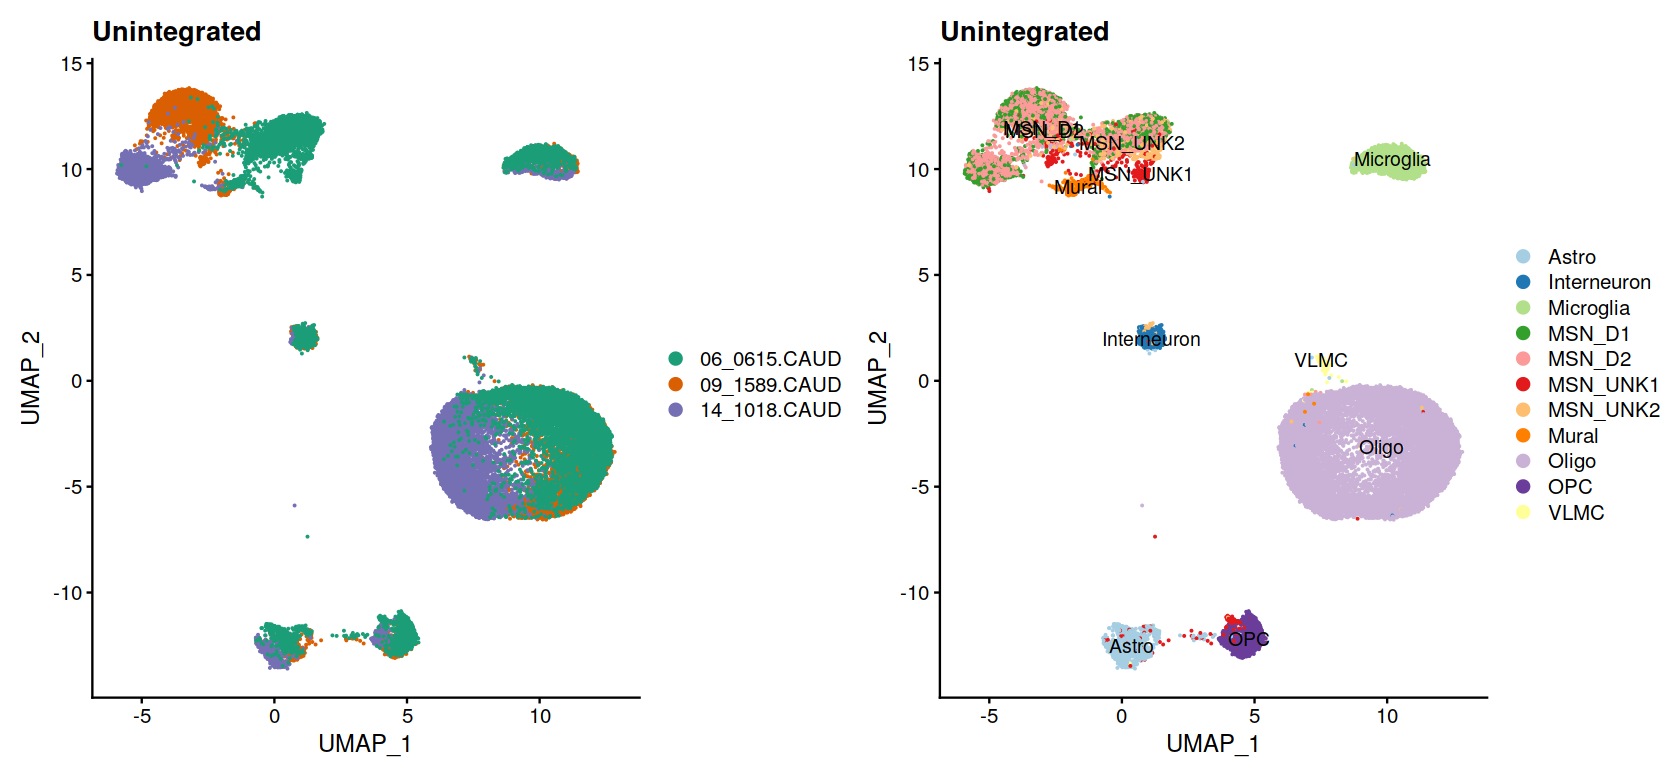

In [5]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Sample', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_species + p_unintegrated_clusters2

# 2) integration with Seurat Intergration

In [6]:
## split seurat object up by species
obj_seurat.list = SplitObject(obj_seurat, split.by = 'Sample')
print(names(obj_seurat.list))
obj_seurat.list = lapply(obj_seurat.list, function(x){
  x <- RunTFIDF(x, verbose = FALSE)
#   x <- FindTopFeatures(x, min.cutoff = 'q5')
  x <- RunSVD(x, verbose = FALSE)
})

# features <- SelectIntegrationFeatures(object.list = obj_seurat.list, nfeatures = 10000)
features <- rownames(obj_seurat)

[1] "09_1589.CAUD" "14_1018.CAUD" "06_0615.CAUD"


In [7]:
# using 14_1018.CAUD as reference
ref = which(names(obj_seurat.list) =="14_1018.CAUD") 

# find integration anchors between species, using all features
anchors <- FindIntegrationAnchors(
        object.list = obj_seurat.list, reduction = 'cca', anchor.features = features,
        reference = c(ref), k.filter = NA, assay = rep('peaks', length(obj_seurat.list)))
gc()

Scaling features for provided objects

Finding anchors between all query and reference datasets

Running CCA

Merging objects

Warning message in CreateChromatinAssay(data = merged.data, min.cells = 0, min.features = 0, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Finding neighborhoods

Finding anchors

	Found 20484 anchors

Running CCA

Merging objects

Warning message in CreateChromatinAssay(data = merged.data, min.cells = 0, min.features = 0, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Finding neighborhoods

Finding anchors

	Found 23241 anchors



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11159906,596.1,17062174,911.3,17062174,911.3
Vcells,3058030989,23331.0,9419279476,71863.4,11774078032,89829.1


In [8]:
# integrate data and create a new merged object
integrated <- IntegrateData(anchors, dims = 2:30, preserve.order = TRUE)

# we now have a "corrected" TF-IDF matrix, and can run LSI again on this corrected matrix
integrated <- RunSVD(integrated, n = 30, reduction.name = 'integratedLSI', verbose = FALSE)
integrated <- RunUMAP(integrated, dims = 2:30, reduction = 'integratedLSI', verbose = FALSE)

Warning message in CreateChromatinAssay(counts = merged.counts, min.cells = 0, min.features = 0, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Integrating dataset 1 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 3 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Adding a command log without an assay associated with it"
Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


# 3) compare integrated snATAC-seq cell types

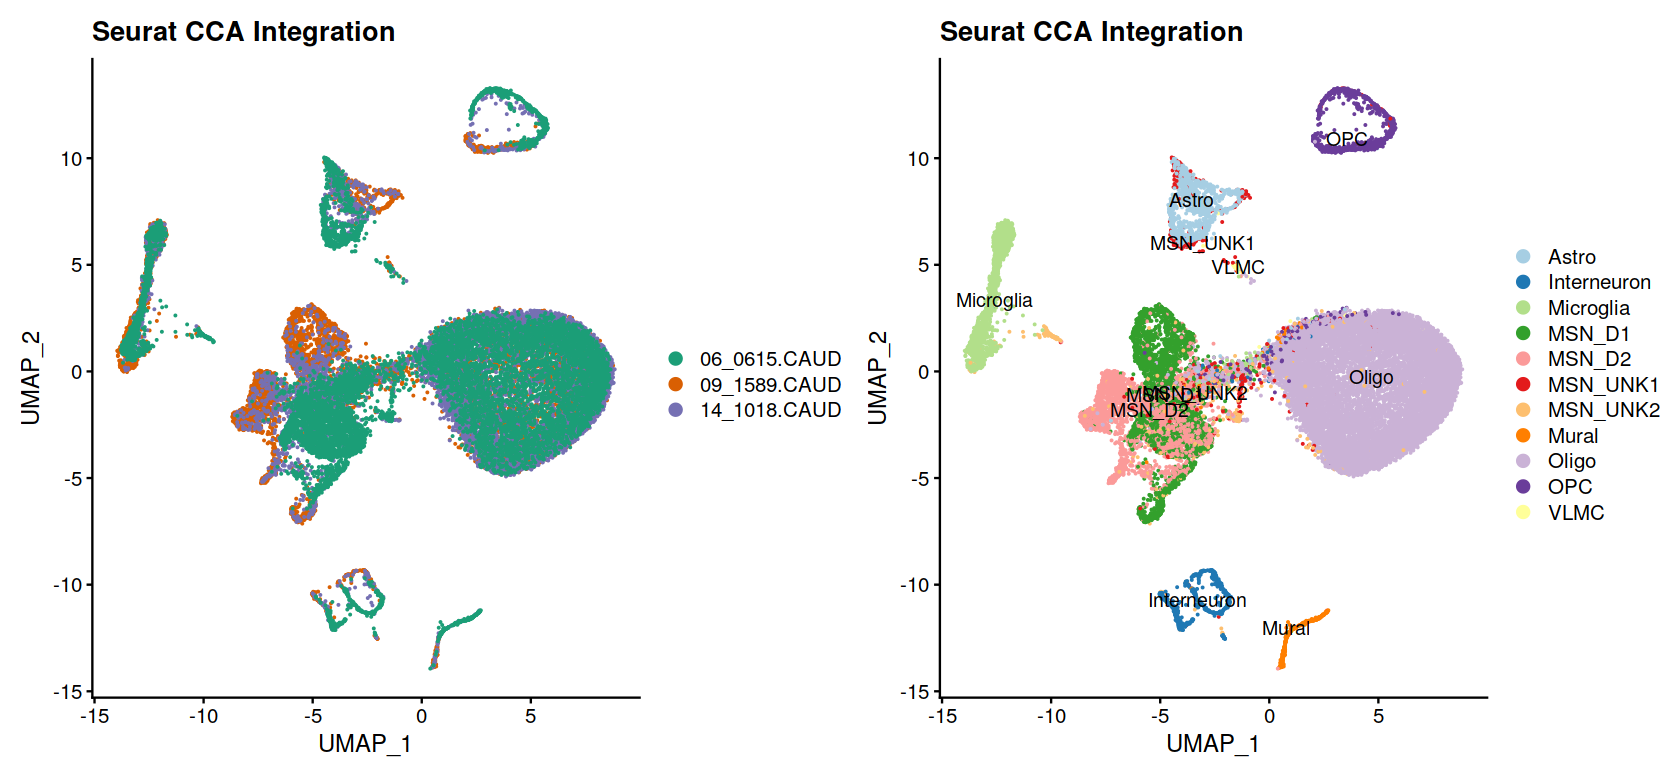

In [9]:
# plot embeddings
p_seuratIntegration_species = 
    DimPlot(object = integrated, label = FALSE, group.by = 'Sample', cols = 'Dark2') +
    ggplot2::ggtitle('Seurat CCA Integration')

p_seuratIntegration_clusters2 = 
    DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
    ggplot2::ggtitle('Seurat CCA Integration')

p_seuratIntegration_species + p_seuratIntegration_clusters2

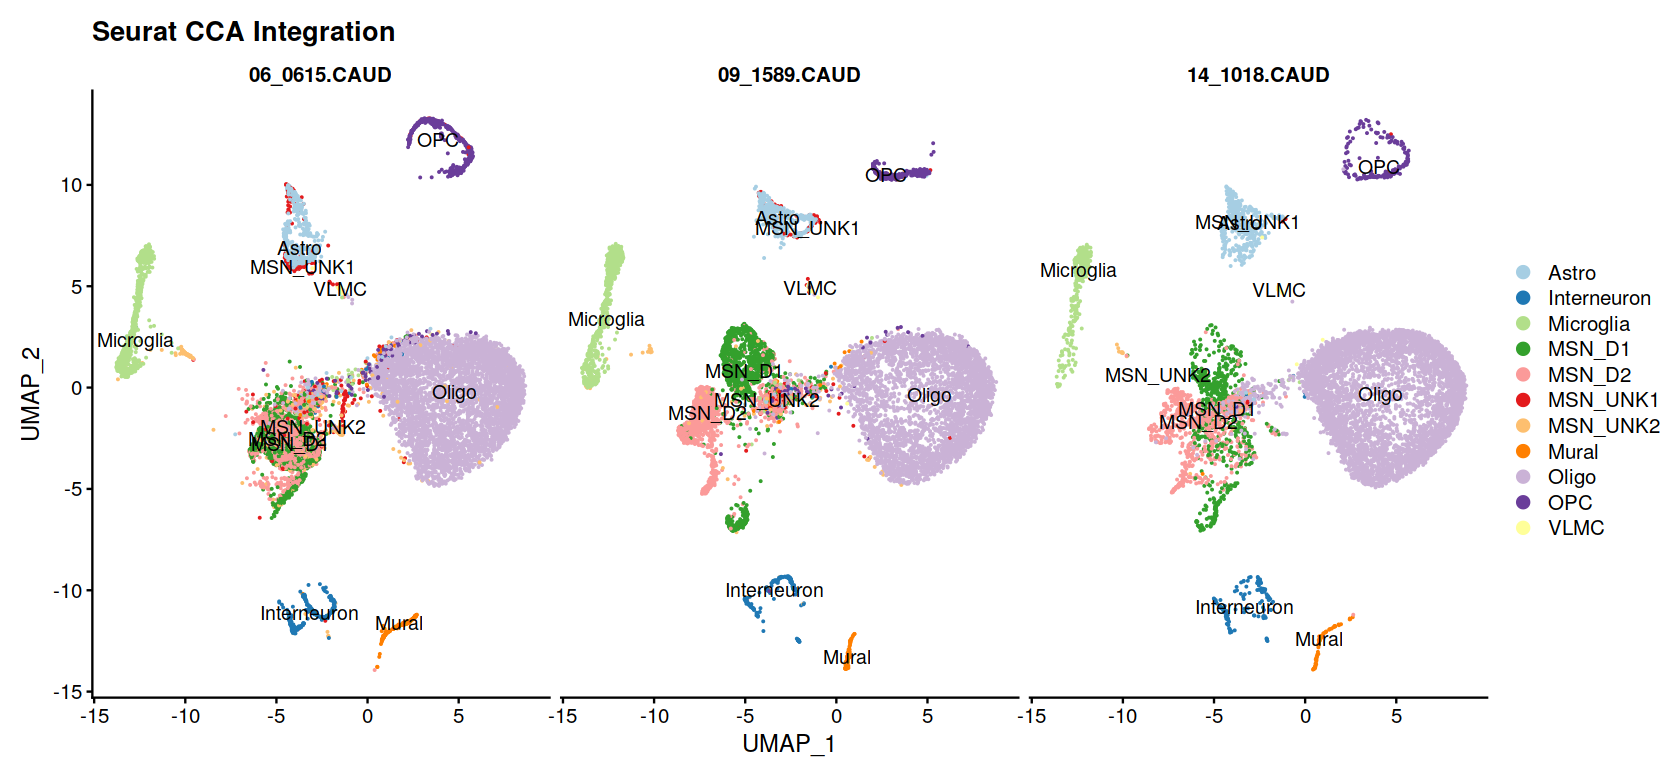

In [10]:
DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'Paired',split.by = 'Sample') +
    ggplot2::ggtitle('Seurat CCA Integration')

In [11]:
rm(obj_seurat.list, obj_seurat, anchors); gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11233184,600.0,17062174,911.3,17062174,911.3
Vcells,4546080968,34683.9,14289099789,109017.2,17654874350,134696.1


In [12]:
integrated
object.size(integrated) / 1024^3

An object of class Seurat 
207766 features across 26314 samples within 2 assays 
Active assay: integrated (103883 features, 103883 variable features)
 1 other assay present: peaks
 2 dimensional reductions calculated: integratedLSI, umap

32.8 bytes

In [13]:
integrated.trim = DietSeurat(
    integrated, counts = TRUE, data = TRUE, scale.data = FALSE, 
    assays = c('peaks', 'integrated'), dimreducs = c('integratedLSI','umap'))

object.size(integrated.trim) / 1024^3

12.4 bytes

In [14]:
## save the seurat object
integratedRDS_fn = file.path(PROJDIR,'rdas','mergedMultiSpeciesSeuratCCAHumanOnly.rds')
saveRDS(integrated, file = integratedRDS_fn)